Install necessary packages:

In [ ]:
!pip install selenium

Import the following modules

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Open the given URL

In [2]:
#options = webdriver.ChromeOptions()
#options.add_argument('--headless=new')
driver = webdriver.Chrome()
url = 'https://www.accuweather.com/en/ph/baguio-city/1-262309_1_al/daily-weather-forecast/1-262309_1_al'

driver.get(url)

Data Scraping

In [3]:
date_raw = driver.find_elements(By.CLASS_NAME, 'date') # extract the dates
temp_raw = driver.find_elements(By.CLASS_NAME, 'temp') # extract the temperature
precip_raw = driver.find_elements(By.CLASS_NAME, 'precip') # extract the precipitation probability 
condition_raw = driver.find_elements(By.CLASS_NAME, 'phrase') # extract the weather condition
realFeel_raw = driver.find_elements(By.CLASS_NAME, 'left') # extract the real feel temperature
uvIndAndWind_raw = driver.find_elements(By.CLASS_NAME, 'right') # extract the max UV index and wind

In [5]:
data = []
for i in range(len(temp_raw)):
    [day, dateMMDD] = date_raw[3*i].text.split('\n')
    [tempHigh, tempLow] = temp_raw[i].text.split(' /')
    [_, realFeelTemp, _, realFeelShade] = realFeel_raw[i+1].text.split('\n')
    [_, maxUV, _, wind] = uvIndAndWind_raw[i+1].text.split('\n')
    [windDirection, windSpeed] = wind.split(' ', 1)
    data.append({
        'day': day,
        'date': dateMMDD,
        'tempHigh': tempHigh,
        'tempLow': tempLow,
        'condition': condition_raw[i].text,
        'precip': precip_raw[i].text,
        'realFeel': realFeelTemp,
        'realFeelShade': realFeelShade,
        'maxUV': maxUV,
        'windDirection': windDirection,
        'windSpeed': windSpeed
    })

df = pd.DataFrame(data)

driver.quit()

df.head(5)


,day,date,tempHigh,tempLow,condition,precip,realFeel,realFeelShade,maxUV,windDirection,windSpeed
0,THU,7/25,21°,19°,Breezy this morning; cloudy with showers and t...,100%,22°,21°,4 Moderate,SW,19 km/h
1,FRI,7/26,23°,20°,A thick cloud cover with a couple of showers a...,96%,27°,24°,5 Moderate,SW,9 km/h
2,SAT,7/27,24°,19°,Considerable cloudiness with a couple of showe...,97%,27°,24°,4 Moderate,WSW,7 km/h
3,SUN,7/28,22°,18°,"Thunderstorms, some can be heavy late; cloudy",95%,25°,22°,4 Moderate,SW,6 km/h
4,MON,7/29,22°,19°,Cloudy with showers and thunderstorms,96%,26°,23°,5 Moderate,WSW,7 km/h


In [6]:
#save the data to a csv file
df.to_csv('weather_data.csv', index=False)

Data Cleaning

In [7]:
weather_data = pd.read_csv('weather_data.csv')

#convert the date column to date format
weather_data['date'] = pd.to_datetime(weather_data['date'] + '/2024').dt.strftime('%m/%d/%Y')

weather_data['tempHigh'] = weather_data['tempHigh'].str.replace('°', '').astype(int)
weather_data['tempLow'] = weather_data['tempLow'].str.replace('°', '').astype(int)
weather_data['precip'] = weather_data['precip'].str.replace('%', '').astype(int)
weather_data['realFeel'] = weather_data['realFeel'].str.replace('°', '').astype(int)
weather_data['realFeelShade'] = weather_data['realFeelShade'].str.replace('°', '').astype(int)
weather_data['maxUV'] = weather_data['maxUV'].str.split(' ').str[0].astype(int)
weather_data['windSpeed'] = weather_data['windSpeed'].str.split(' ').str[0].astype(int)

#drop the day column
weather_data = weather_data.drop(columns=['day', 'condition'])

weather_data.head()

,date,tempHigh,tempLow,precip,realFeel,realFeelShade,maxUV,windDirection,windSpeed
0,07/25/2024,21,19,100,22,21,4,SW,19
1,07/26/2024,23,20,96,27,24,5,SW,9
2,07/27/2024,24,19,97,27,24,4,WSW,7
3,07/28/2024,22,18,95,25,22,4,SW,6
4,07/29/2024,22,19,96,26,23,5,WSW,7


In [8]:
#save the cleaned data to a csv file
weather_data.to_csv('weather_data_clean.csv', index=False)

Data Visualization

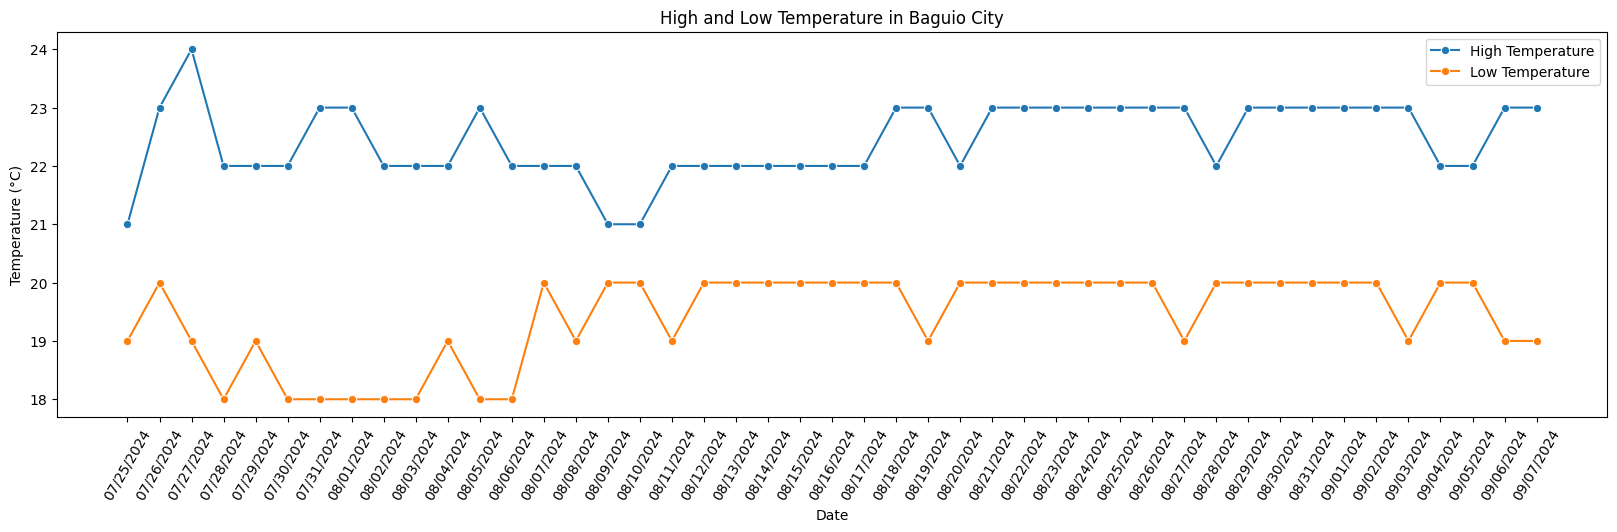

In [9]:
plt.figure(figsize=(20, 5))
sns.lineplot(x='date', y='tempHigh', data=weather_data, label='High Temperature', marker='o')
sns.lineplot(x='date', y='tempLow', data=weather_data, label='Low Temperature', marker='o')
plt.title('High and Low Temperature in Baguio City')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=60)
plt.legend()
plt.show()

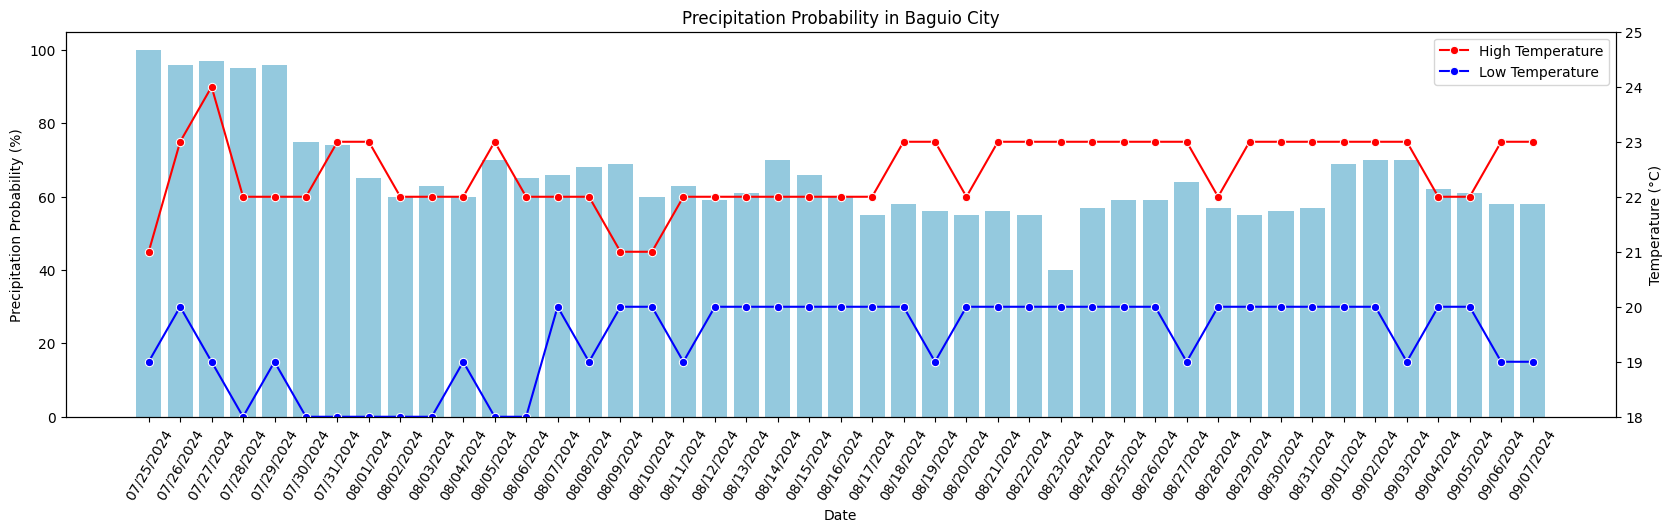

In [11]:
plt.figure(figsize=(20, 5))
sns.barplot(x='date', y='precip', data=weather_data, color='skyblue')
plt.title('Precipitation Probability in Baguio City')
plt.xlabel('Date')
plt.ylabel('Precipitation Probability (%)')
plt.xticks(rotation=60)

ax2 = plt.twinx()
sns.lineplot(x='date', y='tempHigh', data=weather_data, ax=ax2, color='red', label='High Temperature', marker='o')
sns.lineplot(x='date', y='tempLow', data=weather_data, ax=ax2, color='blue', label='Low Temperature', marker='o')
ax2.set_ylim(18, 25)

ax2.set_ylabel('Temperature (°C)')
plt.legend(loc='upper right')

plt.show()


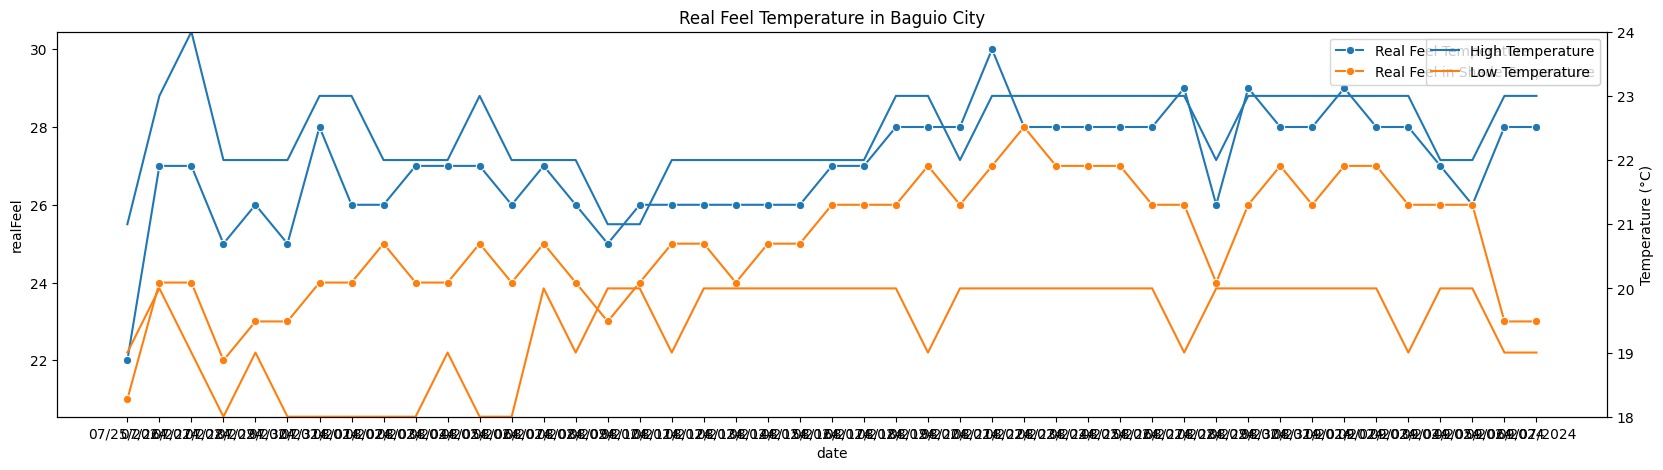

In [12]:
plt.figure(figsize=(20, 5))
sns.lineplot(x='date', y='realFeel', data=weather_data, label='Real Feel Temperature', marker='o')
sns.lineplot(x='date', y='realFeelShade', data=weather_data, label='Real Feel in Shade Temperature', marker='o')
#set the y-axis limit to 40
#plt.ylim(weather_data['realFeelShade'].min, weather_data['realFeel'].max)

ax2 = plt.twinx()
sns.lineplot(x='date', y='tempHigh', data=weather_data, label='High Temperature')
sns.lineplot(x='date', y='tempLow', data=weather_data, label='Low Temperature')
ax2.set_ylim(weather_data['tempLow'].min(), weather_data['tempHigh'].max())
plt.title('Real Feel Temperature in Baguio City')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=60)
plt.legend()

plt.show()

Data Correlation

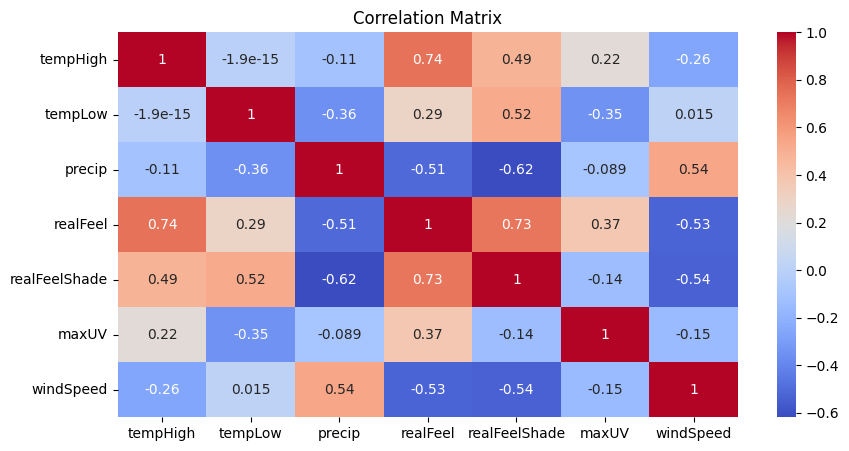

In [13]:
corr_matrix = weather_data[['tempHigh', 'tempLow', 'precip', 'realFeel', 'realFeelShade', 'maxUV', 'windSpeed']].corr()
plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

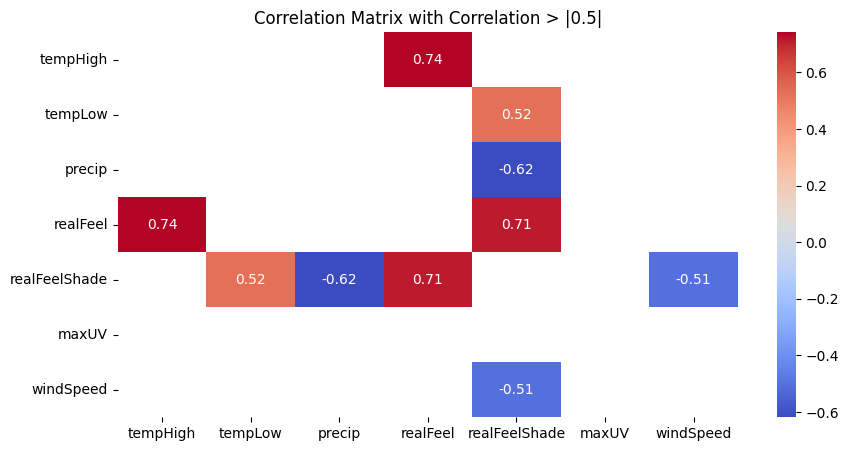

In [192]:
corr_matrix_high = corr_matrix[(corr_matrix.abs() > 0.5) & (corr_matrix.abs() < 1)]
corr_matrix_low = corr_matrix[corr_matrix < 0.5]

plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix_high, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix with Correlation > |0.5|')
plt.show()